In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import os
from PIL import Image

In [2]:
def train(model, train_loader, optimizer, criterion, epochs=5, print_period=100, losses=[], regularization=None, reg_lambda=1e-3):
    model.train()
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for idx, (x_batch, y_batch) in enumerate(train_loader):
            batch_size = y_batch.shape[0]
            loader_size = len(train_loader)
            output = model(x_batch)
            y_pred = torch.nn.functional.softmax(output, dim=1)
            loss = criterion(y_pred, y_batch)
            if regularization is not None:
                if regularization.lower().strip() == "l1":
                    l1_norm = sum(torch.abs(p).sum() for p in model.parameters())
                    loss += l1_norm * reg_lambda
                elif regularization.lower().strip() == "l2":
                    l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                    loss += l2_norm * reg_lambda
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss
            idx += 1
            if (idx % print_period == 0):
                progress = (idx / loader_size)
                print(f"{idx * batch_size} / {loader_size * batch_size} : Progress = {progress:.2%}")
        if epoch%1 == 0:
            losses.append(epoch_loss.detach().cpu())
            print(f"Epoch {epoch}: Loss = {epoch_loss}")
    return losses

In [10]:
def eval(model, val_loader, criterion=None, print_conf=True):
    model.eval()
    y_eval, y_preds = [], []
    val_loss = 0
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch, y_batch
        output = model(x_batch)
        y_pred = F.softmax(output, dim=1)
        if criterion:
            val_loss += criterion(y_pred, y_batch).detach().item()
        y_pred = y_pred.argmax(dim=1)
        y_eval += y_batch.detach().cpu().numpy().tolist()
        y_preds += y_pred.detach().cpu().numpy().tolist()
    if print_conf:
        confusion_matrix = metrics.confusion_matrix(y_eval, y_preds)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        plt.title(f"Confusion matrix")
        plt.show() 
    acc = accuracy_score(y_preds, y_eval)    
    if print_conf:
        print(f"Accuracy Score on validation set: {accuracy_score(y_preds, y_eval):.2%}")
    return acc, val_loss

In [4]:
class imgDataset(Dataset):
    def __init__(self, dir="/home/student/Desktop/220962049_aiml/cats_and_dogs_filtered/train"):
        cats_dir = os.path.join(dir, "cats/")
        dogs_dir = os.path.join(dir, "dogs/")
        self.x = [os.path.join(cats_dir, f) for f in os.listdir(cats_dir) if f.endswith(".jpg")] + [os.path.join(dogs_dir, f) for f in os.listdir(dogs_dir) if f.endswith(".jpg")]
        self.y = [0 for f in os.listdir(cats_dir) if f.endswith(".jpg")] + [1 for f in os.listdir(dogs_dir) if f.endswith(".jpg")]
        self.y = torch.tensor(self.y)
        self.transform = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        img = Image.open(self.x[idx]).convert('RGB')
        tensor = self.transform(img)
        return tensor, self.y[idx]

In [5]:
batch_size = 4
train_set = imgDataset()
val_set = imgDataset(dir="/home/student/Desktop/220962049_aiml/cats_and_dogs_filtered/validation")
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [6]:
from torchvision.models import AlexNet_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
NUM_EPOCHS = 10
losses = []
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=loss_fn,
      epochs=NUM_EPOCHS)

400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 194.81602478027344
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 177.091796875
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 171.8616180419922
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 4: Loss = 168.6572723388672
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 5: Loss = 167.8956756591797
400 / 2000 : Progress = 20.00%
800 / 2

[tensor(194.8160),
 tensor(177.0918),
 tensor(171.8616),
 tensor(168.6573),
 tensor(167.8957),
 tensor(164.5995),
 tensor(165.0976),
 tensor(163.3639),
 tensor(162.2254),
 tensor(160.9991)]

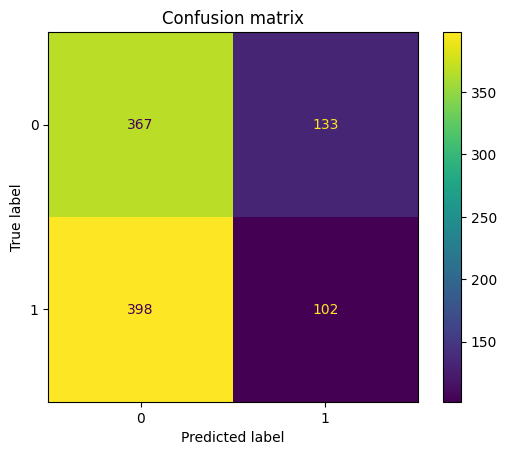

Accuracy Score on validation set: 46.90%


(0.469, 0)

In [11]:
eval(model=model,
     val_loader=val_loader)

In [12]:
from torchvision.models import AlexNet_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
NUM_EPOCHS = 5
losses = []
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=loss_fn,
      epochs=NUM_EPOCHS,
      regularization='l2',
      reg_lambda=1e-3)

400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 4538.40771484375
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 4511.6376953125
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 4497.025390625
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 4: Loss = 4486.34814453125
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 5: Loss = 4474.58984375


[tensor(194.8160),
 tensor(177.0918),
 tensor(171.8616),
 tensor(168.6573),
 tensor(167.8957),
 tensor(164.5995),
 tensor(165.0976),
 tensor(163.3639),
 tensor(162.2254),
 tensor(160.9991),
 tensor(4538.4077),
 tensor(4511.6377),
 tensor(4497.0254),
 tensor(4486.3481),
 tensor(4474.5898)]

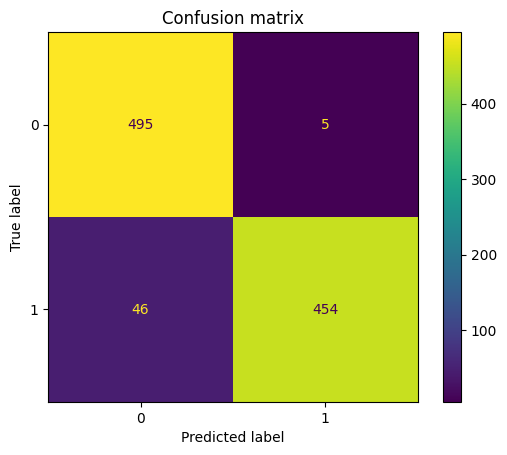

Accuracy Score on validation set: 94.90%


(0.949, 0)

In [14]:
eval(model=model,
     val_loader=val_loader)

In [15]:
from torchvision.models import AlexNet_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 240125.234375
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 226447.21875
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 213373.828125
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 4: Loss = 200884.46875
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 5: Loss = 188976.96875


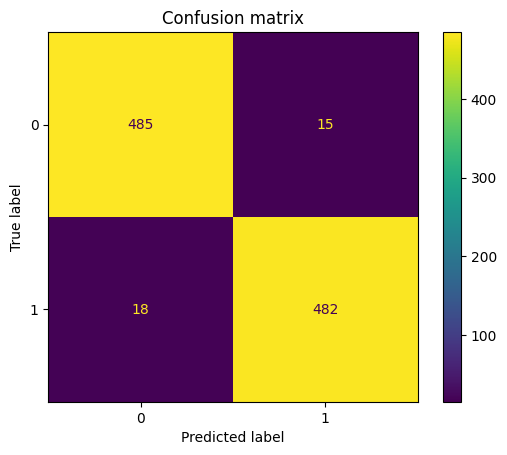

Accuracy Score on validation set: 96.70%


(0.967, 0)

In [16]:
NUM_EPOCHS = 5
losses = []
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=loss_fn,
      epochs=NUM_EPOCHS,
      regularization='l1',
      reg_lambda=1e-3)
eval(model=model,
     val_loader=val_loader)


In [23]:
class DropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3)
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(16*12*12, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.relu(self.pool(self.conv4(x)))
        x = self.drop(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3)
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16*12*12, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.relu(self.pool(self.conv4(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

In [24]:
NUM_EPOCHS = 10
model = DropoutNet()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=criterion,
      epochs=NUM_EPOCHS,
      losses=[])

400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 345.63543701171875
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 339.66387939453125
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 317.0043029785156
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 4: Loss = 299.1698303222656
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 5: Loss = 281.7448425292969
400 / 2000 : Progress = 20.00%
80

[tensor(345.6354),
 tensor(339.6639),
 tensor(317.0043),
 tensor(299.1698),
 tensor(281.7448),
 tensor(275.9840),
 tensor(266.7816),
 tensor(258.9372),
 tensor(252.4154),
 tensor(246.6603)]

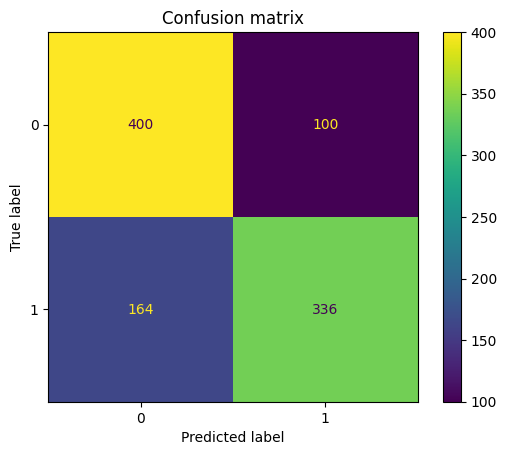

Accuracy Score on validation set: 73.60%


(0.736, 0)

In [25]:
eval(model=model,
     val_loader=val_loader)

In [29]:
from torchvision.models import AlexNet_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
NUM_EPOCHS = 10
patience = 5
best_validation_loss = float('inf')
best_validation_acc = 0.0
current_patience = 0
for epoch in range(1, NUM_EPOCHS+1):
    print(f"Epoch {epoch}:")
    train(model=model,
          train_loader=train_loader,
          optimizer=optimizer,
          criterion=criterion,
          epochs=1,
          losses=[])
    validation_acc, validation_loss = eval(model=model,
                         val_loader=val_loader,
                         criterion=criterion,
                         print_conf=False
                        )
    print(f"Current validation loss: {validation_loss}, validation accuracy: {validation_acc:.2%}")
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_validation_acc = validation_acc
        current_patience = 0
        torch.save(model.state_dict(), './Models/best_model.pth')
    
    else:
        current_patience += 1
    if current_patience > patience:
        print("Early stopping! No improvement for {} epochs.".format(patience))
        break

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Desktop/220962049_aiml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 196.25094604492188
Current validation loss: 88.86044883728027, validation accuracy: 96.10%
Epoch 2:
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 177.34259033203125
Current validation loss: 87.2755106985569, validation accuracy: 96.50%
Epoch 3:
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 172.7517547607422
Current validation loss: 86.789665132761, validation accuracy: 97.30%
Epoch 4:
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Lo

In [30]:
print(f"Best validation loss with early stopiping algorithm: {best_validation_loss}")
print(f"Best validation accuracy with early stopiping algorithm: {best_validation_acc:.2%}")

Best validation loss with early stopiping algorithm: 85.24876534938812
Best validation accuracy with early stopiping algorithm: 97.50%
